## DGAZE: Driver Gaze Mapping on the Road

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Import Packages

In [2]:
import os
from load_dataset import *
from random import shuffle

import keras
from keras.models import Sequential
from keras.regularizers import l2
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Merge, Dropout

from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from keras.regularizers import l1
from keras.layers import BatchNormalization
from keras.optimizers import SGD, Adam, Adamax

from keras.models import model_from_yaml
import copy

Using TensorFlow backend.


In [25]:
## Utils functions

## Metadata
def get_metadata(__dict):
    keys = []
    for key, values in __dict.items():
        keys.append(key)
    return __dict, keys


def print_metadata(driver_data, metakeys):
    drivers_dict, drivers = get_metadata(driver_data)
    seq_dict, sequences = get_metadata(drivers_dict[drivers[0]])
    features_dict, features = get_metadata(seq_dict[sequences[0]])
    
    if 'drivers' in metakeys:
        print("List of Drivers: \n {}\n".format(drivers))
    if 'sequences' in metakeys:
        print("List of Sequences: \n {}\n".format(sequences))
    if 'features' in metakeys:
        print("List of Features: \n {}\n".format(features))
        
        
def get_dgaze_frames_count(driver_data, drivers):
    frames_count = 0
    for driver in drivers:
        data = driver_data[driver]
        frames_count += data['frames_count']
        print("Frames count for driver {} is {}".format(driver, data['frames_count']))
        
    print("\nTotal frames in DGAZE dataset is {}".format(frames_count))



# Split the dataset driver wise and points wise
def split_data(drivers, sequences, dsplit, gp_split):
    """
    Split the data into train-val and test based on number of drivers 
    dsplit = [driver_train_val, driver_test]
    
    Split the data into train, val and test based on number of unique points 
    gp_split = [gaze_point_train, gaze_point_val, gaze_point_test]
    """
    ## Split based on drivers
    drivers_train_val = drivers[:dsplit[0]]
    drivers_test = drivers[dsplit[0]:dsplit[0]+dsplit[1]]

    ## Split based on points
    seq_range = np.arange(0,sequences)
    shuffle(seq_range)
    points_train = seq_range[:gp_split[0]]
    points_val = seq_range[gp_split[0]:gp_split[0]+gp_split[1]]
    points_test = seq_range[gp_split[0]+gp_split[1]:gp_split[0]+gp_split[1]+gp_split[2]]
    
    return drivers_train_val, drivers_test, points_train, points_val, points_test
  
    
def load_data(driver_data, driver, points):
    gaze_point = None
    left_eye = None
    right_eye = None
    headpose_pupil = None
    face_location = None
    
   
    for ix in tqdm((points), position=0, leave=True):
 
        seq = "".join(['seq',str(ix+1)]) 
        
        if seq in driver_data[driver]:
            data = driver_data[driver]["".join(['seq',str(ix+1)])]
        
            if gaze_point is None:
                gaze_point = data['gaze_point']
                left_eye = data['left_eye']
                right_eye = data['right_eye']
                headpose_pupil = data['headpose_pupil']
                face_location = data['face_location']
            else:
                gaze_point = np.concatenate((gaze_point, data['gaze_point']),axis=0)
                left_eye = np.concatenate((left_eye, data['left_eye']),axis=0)
                right_eye = np.concatenate((right_eye, data['right_eye']),axis=0)
                headpose_pupil = np.concatenate((headpose_pupil, data['headpose_pupil']),axis=0)
                face_location = np.concatenate((face_location, data['face_location']),axis=0)
    return left_eye, right_eye, headpose_pupil, face_location, gaze_point


def dataset(drivers, points):
    dgaze_left_eye = None
    dgaze_right_eye = None
    dgaze_headpose_pupil = None
    dgaze_face_location = None
    dgaze_gaze_point = None

    for driver in tqdm((drivers), position=0, leave=True):
        left_eye, right_eye, headpose_pupil, face_location, gaze_point = load_data(driver_data, driver, points)

        if dgaze_left_eye is None:
            dgaze_left_eye = left_eye
            dgaze_right_eye = right_eye
            dgaze_headpose_pupil = headpose_pupil
            dgaze_face_location = face_location
            dgaze_gaze_point = gaze_point
        else:
            dgaze_left_eye = np.concatenate((dgaze_left_eye, left_eye),axis=0)
            dgaze_right_eye = np.concatenate((dgaze_right_eye, right_eye),axis=0)
            dgaze_headpose_pupil = np.concatenate((dgaze_headpose_pupil, headpose_pupil),axis=0)
            dgaze_face_location = np.concatenate((dgaze_face_location, face_location),axis=0)
            dgaze_gaze_point = np.concatenate((dgaze_gaze_point, gaze_point),axis=0)

    return dgaze_left_eye, dgaze_right_eye, dgaze_headpose_pupil, dgaze_face_location, dgaze_gaze_point

def save_model(model_name, model):
    # serialize model to YAML
    model_yaml = model.to_yaml()
    with open(model_name + '.yaml', "w") as yaml_file:
        yaml_file.write(model_yaml)
    # serialize weights to HDF5
    model.save_weights(model_name + ".h5")
    print("Saved model to disk")
    
def load_model(model_name):
    yaml_file = open(model_name + '.yaml', 'r')
    loaded_model_yaml = yaml_file.read()
    yaml_file.close()
    loaded_model = model_from_yaml(loaded_model_yaml)
    # load weights into new model
    loaded_model.load_weights(model_name + ".h5")
    print("Loaded model from disk")
    return loaded_model

def load_model2(model, model_name):
    model.load_weights(model_name)
    print("Loaded model from disk")
    return model

### Load Dataset

In [4]:
data_path = '/ssd_scratch/cvit/isha/eye_gaze_mapping/DGM_final2/dataset_samples_callibrated/'
drivers = os.listdir(data_path)
ndrivers = len(drivers)
frames_per_seq = 50
sequences = 112

driver_data = get_data(data_path, drivers, sequences, frames_per_seq)

#print_metadata(driver_data, ['features'])
#get_dgaze_frames_count(driver_data, drivers)

100%|██████████| 20/20 [00:05<00:00,  3.30it/s]


### Dataset split

In [5]:
dsplit = [15,5]
gp_split = [72,20,20]
drivers_train_val, drivers_test, points_train, points_val, points_test = \
                                    split_data(drivers, sequences, dsplit, gp_split)
print("For train points")
train_left_eye, train_right_eye, train_headpose_pupil, train_face_location, train_gaze_point = dataset(drivers_train_val, points_train)

print("For val points")
val_left_eye, val_right_eye, val_headpose_pupil, val_face_location, val_gaze_point = dataset(drivers_train_val, points_val)

print("For test points")
test_left_eye, test_right_eye, test_headpose_pupil, test_face_location, test_gaze_point =dataset(drivers_train_val, points_test)

print("For test drivers")
dtest_left_eye, dtest_right_eye, dtest_headpose_pupil, dtest_face_location, dtest_gaze_point = dataset(drivers_test, np.arange(0,sequences))


 25%|██▌       | 18/72 [00:00<00:00, 168.12it/s]

For train points


  0%|          | 0/20 [00:00<?, ?it/s].60it/s]

For val points


100%|██████████| 20/20 [00:00<00:00, 222.10it/s]


For test points


 21%|██▏       | 24/112 [00:00<00:00, 237.30it/s]

For test drivers


100%|██████████| 5/5 [00:43<00:00,  9.06s/it]


In [6]:
print(train_left_eye.shape, train_right_eye.shape, train_headpose_pupil.shape, train_face_location.shape, train_gaze_point.shape 
)
print(val_left_eye.shape, val_right_eye.shape, val_headpose_pupil.shape, val_face_location.shape, val_gaze_point.shape)
print(test_left_eye.shape, test_right_eye.shape, test_headpose_pupil.shape, test_face_location.shape, test_gaze_point.shape)
print(dtest_left_eye.shape, dtest_right_eye.shape, dtest_headpose_pupil.shape, dtest_face_location.shape, dtest_gaze_point.shape)

(107490, 36, 60, 3) (107490, 36, 60, 3) (107490, 11) (107490, 4) (107490, 6)
(29369, 36, 60, 3) (29369, 36, 60, 3) (29369, 11) (29369, 4) (29369, 6)
(32579, 36, 60, 3) (32579, 36, 60, 3) (32579, 11) (32579, 4) (32579, 6)
(57740, 36, 60, 3) (57740, 36, 60, 3) (57740, 11) (57740, 4) (57740, 6)


In [7]:
train_range = np.arange(0, train_gaze_point.shape[0])
val_range = np.arange(0, val_gaze_point.shape[0])
test_range = np.arange(0, test_gaze_point.shape[0])

shuffle(train_range)
shuffle(val_range)
shuffle(test_range)

train_left_eye, train_right_eye, train_headpose_pupil, train_face_location, train_gaze_point = \
    train_left_eye[train_range], train_right_eye[train_range], train_headpose_pupil[train_range], train_face_location[train_range], train_gaze_point[train_range]
    
val_left_eye, val_right_eye, val_headpose_pupil, val_face_location, val_gaze_point = \
    val_left_eye[val_range], val_right_eye[val_range], val_headpose_pupil[val_range], val_face_location[val_range], val_gaze_point[val_range]
    
test_left_eye, test_right_eye, test_headpose_pupil, test_face_location, test_gaze_point = \
    test_left_eye[test_range], test_right_eye[test_range], test_headpose_pupil[test_range], test_face_location[test_range], test_gaze_point[test_range]

In [8]:
import matplotlib.patches as patches

def plot_gaze_points(gaze_point):
    cap = cv2.VideoCapture(data_path + 'user12/original_road_view/sample_56.avi')
    ret, frame = cap.read()
    
    y = np.where(gaze_point[:,0]>=1920)
    gaze_point[y[0], 0]=1919
    y = np.where(gaze_point[:,0]<0)
    gaze_point[y[0],0]=0
    y = np.where(gaze_point[:,1]>=1080)
    gaze_point[y[0], 1]=1080
    y = np.where(gaze_point[:,1]<0)
    gaze_point[y[0], 1]=0

    plt.figure()
    plt.imshow(frame)
    plt.scatter(gaze_point[:,0], gaze_point[:,1], c='r')


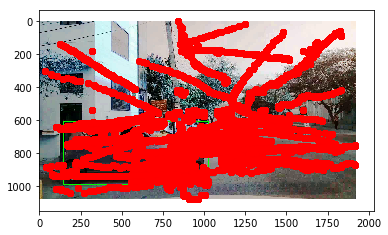

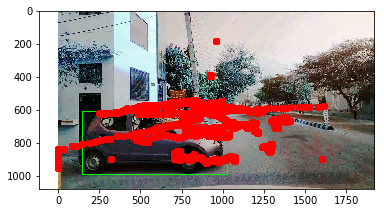

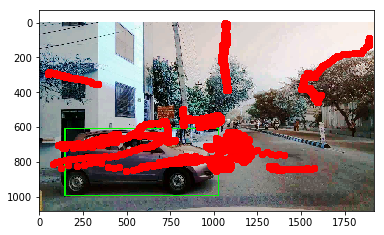

In [9]:
plot_gaze_points(train_gaze_point)
plot_gaze_points(val_gaze_point)
plot_gaze_points(test_gaze_point)

### I-DGAZE: Predicting driver gaze on road

In [38]:
model1 = Sequential()
model1.add(Conv2D(20, kernel_size=(5,5),activation='relu',input_shape=(36,60,3)))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.5))
model1.add(Conv2D(50, (5,5), activation='relu',kernel_regularizer=l1(0.001), bias_regularizer=l1(0.001)))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.5))
model1.add(Flatten())
model1.add(Dense(500, activation='relu', kernel_regularizer=l1(0.001), bias_regularizer=l1(0.001)))
# model1.add(Dense(128, activation='relu', kernel_regularizer=l1(0.001), bias_regularizer=l1(0.001)))

model2 = Sequential()
model2.add(Dense(100, activation ='relu', input_dim=(14)))
model2.add(Dense(32, activation ='relu'))

model3 = Sequential()
model3.add(Merge([model1, model2], mode = 'concat'))
# model3.add(Dense(1024, activation='relu', kernel_regularizer=l1(0.001), bias_regularizer=l1(0.001)))
# model3.add(Dense(128, activation='relu', kernel_regularizer=l1(0.001), bias_regularizer=l1(0.001)))
model3.add(Dense(32, activation='relu', kernel_regularizer=l1(0.001), bias_regularizer=l1(0.001)))
#model3.add(Dense(500))
model3.add(Dense(2))
model1.summary(), model2.summary(), model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 56, 20)        1520      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 28, 20)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 28, 20)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 24, 50)        25050     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 12, 50)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 6, 12, 50)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3600)              0         
__________

(None, None, None)

In [11]:
from sklearn import preprocessing
train_face_features = np.concatenate((train_headpose_pupil[:,[1,2,3,4,5,6,7,8,9,10]],train_face_location[:]), axis =1)
val_face_features = np.concatenate((val_headpose_pupil[:,[1,2,3,4,5,6,7,8,9,10]],val_face_location[:]), axis =1)
test_face_features = np.concatenate((test_headpose_pupil[:,[1,2,3,4,5,6,7,8,9,10]],test_face_location[:]), axis =1)

mm_scaler = preprocessing.MinMaxScaler()
train_face_features = mm_scaler.fit_transform(train_face_features)
val_face_features = mm_scaler.transform(val_face_features)
test_face_features = mm_scaler.transform(test_face_features)



In [127]:

mc = keras.callbacks.ModelCheckpoint('weights_points_normalized/lweights{epoch:04d}.h5', 
                                     save_weights_only=True, period=1)
# model_name = "weights/model1"
opt = Adam(lr=0.0000001)

model3.compile(loss='mae', optimizer=opt)
earlystopping = keras.callbacks.EarlyStopping(monitor = 'val_loss',min_delta = 1, patience =3, verbose =0, mode ='auto')

history = model3.fit([train_left_eye, train_face_features], train_gaze_point[:,:2], \
                      validation_data=([val_left_eye, val_face_features],val_gaze_point[:,:2]),\
                     epochs=30, batch_size=40, callbacks=[mc], verbose=1, shuffle= True)
print(history.history.keys())

# save_model(model_name, model3)

Train on 107490 samples, validate on 29369 samples
Epoch 1/30
107490/107490 [==============================] - 20s 185us/step - loss: 137.2898 - val_loss: 159.8891
Epoch 2/30
107490/107490 [==============================] - 19s 174us/step - loss: 136.9084 - val_loss: 159.9891
Epoch 3/30
107490/107490 [==============================] - 19s 174us/step - loss: 136.8566 - val_loss: 159.9858
Epoch 4/30
107490/107490 [==============================] - 18s 172us/step - loss: 137.0490 - val_loss: 159.9975
Epoch 5/30
107490/107490 [==============================] - 18s 171us/step - loss: 136.7037 - val_loss: 160.0624
Epoch 6/30
107490/107490 [==============================] - 18s 172us/step - loss: 136.6680 - val_loss: 159.9785
Epoch 7/30
107490/107490 [==============================] - 19s 174us/step - loss: 136.8191 - val_loss: 160.0025
Epoch 8/30
107490/107490 [==============================] - 19s 172us/step - loss: 136.6673 - val_loss: 160.2317
Epoch 9/30
107490/107490 [===================

KeyboardInterrupt: 

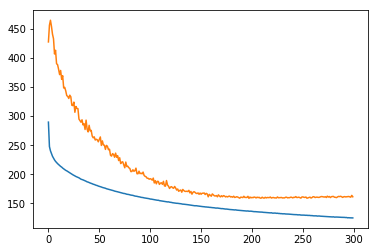

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [36]:
def gaze_error(left_eye, face_features, gaze_point):
    scores = model3.evaluate([left_eye, face_features], gaze_point)
    return scores

In [132]:
train_error = gaze_error(train_left_eye, train_face_features, train_gaze_point[:,:2])
val_error = gaze_error(val_left_eye, val_face_features, val_gaze_point[:,:2])
test_error = gaze_error(test_left_eye, test_face_features, test_gaze_point[:,:2])
    
print("Train Error ==> ", train_error)
print("Val Error ==> ",  val_error)
print("Test Error ==> " ,test_error)

32579/32579 [==============================] - 4s 115us/step
Train Error ==>  131.15335752185706
Val Error ==>  158.80922485827475
Test Error ==>  199.02431671518204


In [131]:
opt = Adam(lr=0.00001)
model3.compile(loss='mae', optimizer=opt)
model3.load_weights('weights_points_normalized/weights0189.h5')

## Plot output

In [56]:
def plot_out(driver, train_points, test_points, model, frame_no):

    driver_frame_out = None

    for tp in points_test:
        road_video = data_path + drivers[0] + "/original_road_view/sample_" +str(tp+1)+".avi"
        driver_video = data_path + drivers[0] + "/driver_view/sample_" +str(tp+1)+".avi"

        if "".join(['seq',str(tp+1)]) in driver_data[driver[0]]:
            tr_left_eye, tr_right_eye, tr_headpose_pupil, tr_face_location, tr_gaze_point = dataset(driver, train_points)
            te_data = driver_data[driver[0]]["".join(['seq',str(tp+1)])]

            gaze_point = te_data['gaze_point']
            left_eye = te_data['left_eye']
            right_eye = te_data['right_eye']
            headpose_pupil = te_data['headpose_pupil']
            face_location = te_data['face_location']
            
            face_features = np.concatenate((headpose_pupil[:,[1,2,3,4,5,6,7,8,9,10]],face_location[:]), axis =1)
            tr_face_features = np.concatenate((tr_headpose_pupil[:,[1,2,3,4,5,6,7,8,9,10]],tr_face_location[:]), axis =1)

            face_features = mm_scaler.transform(face_features)
            tr_face_features = mm_scaler.transform(tr_face_features)
           # model = load_model2(model3, 'weights_points_normalized/weights0189.h5')
            
            scores1 = model3.evaluate([left_eye, face_features], gaze_point[:,:2])
            pred_bef_calib = model3.predict([left_eye, face_features])

            model3.fit([tr_left_eye, tr_face_features], tr_gaze_point[:,:2], \
                       validation_data=([left_eye, face_features],gaze_point[:,:2]),\
                             epochs=20, batch_size=40,verbose=1, shuffle= True)

            pred_after_calib = model3.predict([left_eye, face_features])
            scores2 = model3.evaluate([left_eye, face_features], gaze_point[:,:2])
            print(scores1, scores2)
            road_vid = cv2.VideoCapture(road_video)
            driver_vid = cv2.VideoCapture(driver_video)

            for i in range(0,frame_no):
                ret,road_frame = road_vid.read()
                ret1, driver_frame = driver_vid.read()

            frame_gt = cv2.circle(road_frame,(gaze_point[frame_no,0], gaze_point[frame_no,1]), 70, (0,255,0), -1 )
            frame_pred = cv2.circle(frame_gt,(pred_bef_calib[frame_no,0], pred_bef_calib[frame_no,1]), 70, (0,0,255), -1 )


            frame_bef = road_frame.copy()
            frame_after= road_frame.copy()
            for i in range(0, gaze_point.shape[0]):
                frame_bef = cv2.circle(frame_bef,(gaze_point[i,0], gaze_point[i,1]), 70, (0,255,0), -1 )    
                frame_bef = cv2.circle(frame_bef,(pred_bef_calib[i,0], pred_bef_calib[i,1]), 70, (0,0,255), -1)  

                frame_after = cv2.circle(frame_after,(gaze_point[i,0], gaze_point[i,1]), 70, (0,255,0), -1 )    
                frame_after = cv2.circle(frame_after,(pred_after_calib[i,0], pred_after_calib[i,1]), 70, (0,0,255), -1)  


            frame_out = driver_frame
            frame_out = np.concatenate((frame_out, frame_gt), axis =1)
            frame_out = np.concatenate((frame_out, frame_pred), axis =1)
            frame_out = np.concatenate((frame_out, frame_bef), axis =1)
            frame_out = np.concatenate((frame_out, frame_after), axis =1)

            if driver_frame_out is None:
                driver_frame_out = frame_out
            else:
                driver_frame_out = np.concatenate((driver_frame_out, frame_out), axis =0)
            break

    return driver_frame_out


In [57]:
driver = [drivers_train_val[0]]
train_points = np.arange(0,9)
test_points = points_test
model = model3
frame_no = 25

out = plot_out(driver, train_points, test_points, model, frame_no)

100%|██████████| 1/1 [00:00<00:00, 55.00it/s]

79/79 [==============================] - 0s 2ms/step


Train on 870 samples, validate on 79 samples
Epoch 1/20
870/870 [==============================] - 1s 914us/step - loss: 231.8535 - val_loss: 169.3588
Epoch 2/20
870/870 [==============================] - 0s 166us/step - loss: 184.1994 - val_loss: 172.6201
Epoch 3/20
870/870 [==============================] - 0s 162us/step - loss: 168.0211 - val_loss: 186.5350
Epoch 4/20
870/870 [==============================] - 0s 161us/step - loss: 157.3882 - val_loss: 222.1058
Epoch 5/20
870/870 [==============================] - 0s 163us/step - loss: 156.7802 - val_loss: 201.0576
Epoch 6/20
870/870 [==============================] - 0s 161us/step - loss: 151.6100 - val_loss: 196.5746
Epoch 7/20
870/870 [==============================] - 0s 162us/step - loss: 145.4173 - val_loss: 211.5911
Epoch 8/20
870/870 [==============================] - 0s 163us/step - loss: 142.8525 - val_loss: 194.6899
Epoch 9/20
870/870 [==============================] - 0s 160us/step - loss: 142.8238 - val_loss: 205.9053
E

In [117]:
driver = [drivers_train_val[0]]
train_points = np.arange(0,15)
test_points = points_test
model = model3
frame_no = 25


In [118]:
tr_left_eye, tr_right_eye, tr_headpose_pupil, tr_face_location, tr_gaze_point = dataset(driver, train_points)
te_left_eye, te_right_eye, te_headpose_pupil, te_face_location, te_gaze_point = dataset(driver, test_points)

100%|██████████| 1/1 [00:00<00:00, 21.45it/s]


In [119]:
tr_gaze_point.shape, te_gaze_point.shape

((1325, 6), (1766, 6))

In [120]:
te_face_features = np.concatenate((te_headpose_pupil[:,[1,2,3,4,5,6,7,8,9,10]],te_face_location[:]), axis =1)
tr_face_features = np.concatenate((tr_headpose_pupil[:,[1,2,3,4,5,6,7,8,9,10]],tr_face_location[:]), axis =1)

te_face_features = mm_scaler.transform(te_face_features)
tr_face_features = mm_scaler.transform(tr_face_features)

In [121]:
opt = Adam(lr=0.0000001)
model3.compile(loss='mae', optimizer=opt)
model3.load_weights('weights_points_normalized/weights0189.h5')

In [122]:
scores1 = model3.evaluate([te_left_eye, te_face_features], te_gaze_point[:,:2])
scores1

1766/1766 [==============================] - 0s 206us/step


194.19223820825664

In [123]:
model3.fit([tr_left_eye, tr_face_features], tr_gaze_point[:,:2], \
           validation_data=([te_left_eye, te_face_features],te_gaze_point[:,:2]),\
                 epochs=20, batch_size=40,verbose=1, shuffle= True)


Train on 1325 samples, validate on 1766 samples
Epoch 1/20
1325/1325 [==============================] - 1s 939us/step - loss: 222.6326 - val_loss: 193.7985
Epoch 2/20
1325/1325 [==============================] - 0s 229us/step - loss: 223.1102 - val_loss: 193.4599
Epoch 3/20
1325/1325 [==============================] - 0s 228us/step - loss: 221.5604 - val_loss: 193.2213
Epoch 4/20
1325/1325 [==============================] - 0s 226us/step - loss: 219.7514 - val_loss: 193.0370
Epoch 5/20
1325/1325 [==============================] - 0s 227us/step - loss: 218.7819 - val_loss: 192.9248
Epoch 6/20
1325/1325 [==============================] - 0s 227us/step - loss: 216.7486 - val_loss: 192.8889
Epoch 7/20
1325/1325 [==============================] - 0s 227us/step - loss: 217.4810 - val_loss: 192.8773
Epoch 8/20
1325/1325 [==============================] - 0s 225us/step - loss: 215.1039 - val_loss: 192.8751
Epoch 9/20
1325/1325 [==============================] - 0s 226us/step - loss: 216.3168 -

In [125]:
scores1 = model3.evaluate([te_left_eye, te_face_features], te_gaze_point[:,:2])
scores1

1766/1766 [==============================] - 0s 76us/step


194.6167054656948